In [1240]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn.metrics as metrics
import sklearn.preprocessing as prep
import sklearn.model_selection as ms
from functools import partial
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [1409]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OSI/overlap_OSI(50%)_train.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OSI/overlap_OSI(50%)_test.csv")

# Overlap ARDS
ARDS = pd.read_csv("~/project/MIMIC-III/ARDS.csv")
ARDS.drop("y", axis=1, inplace=True)

train_data = pd.merge(train_data, ARDS, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
test_data = pd.merge(test_data, ARDS, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["GENDER"])
test_data = pd.get_dummies(test_data, columns=["GENDER"])

# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    
####################################################################
# Down Sampling

# n:1
# train 데이터의 레이블 비율 확인
train_labels = train_data['y']
label_counts = train_labels.value_counts()

# train 데이터의 레이블 비율이 n:1이 되도록 분할
num_samples_class_0 = int(label_counts[1] * 1.8)  # 레이블 0을 레이블 1의 n배로 설정
num_samples_class_1 = label_counts[1]  # 레이블 1의 모든 샘플 개수

class_0_data = train_data[train_data['y'] == 0]
class_1_data = train_data[train_data['y'] == 1]

# 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
class_1_data = class_1_data.sample(num_samples_class_1, random_state=42)

# 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
class_0_data = class_0_data.sample(num_samples_class_0, random_state=42)

# 선택한 데이터를 결합하여 최종 train 데이터 생성
train_data = pd.concat([class_0_data, class_1_data])


# # 1:1
# # train 데이터의 레이블 비율 확인
# train_labels = train_data['y']
# label_counts = train_labels.value_counts()

# # train 데이터의 레이블 비율이 1:1이 되도록 분할
# class_0_data = train_data[train_data['y'] == 0]
# class_1_data = train_data[train_data['y'] == 1]

# # 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
# num_samples = min(label_counts[0], label_counts[1])
# class_0_data = class_0_data.sample(num_samples, random_state=42)

# # 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
# class_1_data = class_1_data.sample(num_samples, random_state=42)

# # 선택한 데이터를 결합하여 최종 train 데이터 생성
# train_data = pd.concat([class_0_data, class_1_data])
####################################################################


# Features와 Target 설정
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)

print("train shape\n",X_train.shape,"\n")
print("train shape\n",X_test.shape,"\n")

target = "y"
features = [f for f in train_data.columns if f not in [target]]

print("train value\n",train_data['y'].value_counts())
print("test value\n",test_data['y'].value_counts())

train shape
 (3217, 130) 

train shape
 (1421, 130) 

train value
 0    2068
1    1149
Name: y, dtype: int64
test value
 0    1037
1     384
Name: y, dtype: int64


In [1410]:
# test_data와 train_data의 칼럼 차이 확인
column_difference = set(X_train.columns) - set(X_test.columns)
print("칼럼 차이:", column_difference)

칼럼 차이: set()


In [1411]:
model=xgb.XGBClassifier(seed=1,
            tree_method="gpu_hist",
            gpu_id=0,
            predictor="gpu_predictor",
            n_estimators=100)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor='gpu_predictor', random_state=None, ...)

In [1412]:
y_pred2 = model.predict(X_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(train_data['y'], y_pred2)
print("Train Accuracy:", accuracy) 

# Precision, Recall, F1-score 계산
precision = precision_score(test_data['y'], y_pred)
recall = recall_score(test_data['y'], y_pred)
f1 = f1_score(test_data['y'], y_pred)
accuracy = accuracy_score(test_data['y'], y_pred)

# print("Test Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)

rounded_accuracy = round(accuracy * 100, 2)
rounded_precision = round(precision * 100, 2)
rounded_recall = round(recall * 100, 2)
rounded_f1 = round(f1 * 100, 2)

print("Test Accuracy:", rounded_accuracy)
print("Precision:", rounded_precision)
print("Recall:", rounded_recall)
print("F1-score:", rounded_f1)

Train Accuracy: 1.0
Test Accuracy: 73.75
Precision: 51.67
Recall: 44.27
F1-score: 47.69


In [1413]:
class CrossValidation:
    def __init__(self, df, shuffle,random_state=None):
        self.df = df
        self.random_state = random_state
        self.shuffle = shuffle
        if shuffle is True:
            self.df = df.sample(frac=1,
                random_state=self.random_state).reset_index(drop=True)

    def hold_out_split(self,percent,stratify=None):
        if stratify is not None:
            y = self.df[stratify]
            train,val = ms.train_test_split(self.df, test_size=percent/100,
                stratify=y, random_state=self.random_state)
            return train,val
        size = len(self.df) - int(len(self.df)*(percent/100))
        train = self.df.iloc[:size,:]
        val = self.df.iloc[size:,:]
        return train,val

    def kfold_split(self, splits, stratify=None):
        if stratify is not None:
            kf = ms.StratifiedKFold(n_splits=splits,
                shuffle=self.shuffle,
                random_state=self.random_state)
            y = self.df[stratify]
            for train, val in kf.split(X=self.df,y=y):
                t = self.df.iloc[train,:]
                v = self.df.iloc[val, :]
                yield t,v
        else:
            kf = ms.KFold(n_splits=splits, shuffle=self.shuffle,
                random_state=self.random_state)
            for train, val in kf.split(X=self.df):
                t = self.df.iloc[train,:]
                v = self.df.iloc[val, :]
                yield t,v
seed = 42
folds = 5
cv = CrossValidation(train_data,
                     shuffle=True,
                     random_state=seed
                    )

In [1414]:
def tuning_params(trial):
    # gamma = trial.suggest_categorical("gamma", [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 204.8])
    n_estimators = trial.suggest_int("n_estimators", 100, 2000, step=50)
    # learning_rate = trial.suggest_float("learning_rate", 0.01, 0.4, step=0.01)
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True)
    subsample = trial.suggest_float("subsample", 0.1, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0, step=0.1)
    max_depth = trial.suggest_categorical("max_depth", [3, 4, 5, 6, 7, 8, 9, 10])

# # def tuning_params(trial):
# #     gamma = trial.suggest_categorical("gamma", [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200])
# #     subsample = trial.suggest_float("subsample", 0.1, 1.0)
# #     colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)             
# #     n_estimators = trial.suggest_categorical("n_estimators", [50, 65, 80, 100, 115, 130, 150])
# #     learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
# #     max_depth = trial.suggest_categorical("max_depth", [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
# #     reg_alpha = trial.suggest_categorical("reg_alpha", [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200])
# #     reg_lambda = trial.suggest_categorical("reg_lambda", [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200])
    
    
# def tuning_params(trial):
#     gamma = trial.suggest_categorical("gamma", [i * 0.1 for i in range(1, 301)])
#     n_estimators = trial.suggest_int("n_estimators", 100, 2000, step=50)
#     learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01)
#     reg_alpha = trial.suggest_categorical("reg_alpha", [i * 0.1 for i in range(1, 301)])
#     reg_lambda = trial.suggest_categorical("reg_lambda", [i * 0.1 for i in range(1, 301)])
#     subsample = trial.suggest_float("subsample", 0.3, 1.0, step=0.1)
#     colsample_bytree = trial.suggest_float("colsample_bytree", 0.3, 1.0, step=0.1)
#     max_depth = trial.suggest_categorical("max_depth", [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

    for train_, val_ in cv.kfold_split(folds):
        trainX = train_[features]
        trainY = train_[target]
        valX = val_[features]
        valY = val_[target]
        
        model = xgb.XGBClassifier(
            seed=1,
            tree_method="gpu_hist",
            gpu_id=0,
            predictor="gpu_predictor",
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            reg_lambda=reg_lambda,
            reg_alpha=reg_alpha,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            max_depth=max_depth,
            use_label_encoder=False,
            early_stopping_rounds=300, 
                 
        )
        
        model.fit(trainX, trainY, 
                   eval_set=[(valX, valY)],
                  verbose=False
                 )
    
        predY = model.predict(valX)
        val_f1 = f1_score(valY, predY)# Calculate F1-score
        return val_f1
    
        # val_auc = metrics.roc_auc_score(valY, predY)
        # return val_auc

In [1415]:
# # 목표 F1 score 설정
# target_f1_score = 0.72

# # Optuna study 생성
# study = optuna.create_study(direction="maximize")

# # 목표 F1 score가 달성될 때까지 반복
# while True:
#     # 새로운 trial 시작
#     study.optimize(tuning_params, n_trials=1, gc_after_trial=True)
    
#     # 현재의 최적 F1 score 가져오기
#     best_f1_score = study.best_value
    
#     # 현재 F1 score가 목표 F1 score를 넘으면 반복 중단
#     if best_f1_score >= target_f1_score:
#         print("목표 F1 Score 달성!")
#         break

In [1416]:
study = optuna.create_study(direction="maximize")
study.optimize(tuning_params, n_trials=100, gc_after_trial=True)

[I 2023-09-05 15:11:32,318] A new study created in memory with name: no-name-2cf1d1be-ca51-4ae7-8cea-f2fc3a7b3c87
[I 2023-09-05 15:11:39,641] Trial 0 finished with value: 0.36129032258064514 and parameters: {'n_estimators': 1850, 'learning_rate': 0.013092251714242926, 'reg_lambda': 0.27020393494925987, 'reg_alpha': 4.917313993627902e-06, 'subsample': 0.9, 'colsample_bytree': 0.1, 'max_depth': 10}. Best is trial 0 with value: 0.36129032258064514.
[I 2023-09-05 15:11:43,416] Trial 1 finished with value: 0.47696476964769646 and parameters: {'n_estimators': 500, 'learning_rate': 0.09099374761038254, 'reg_lambda': 0.7949462549193786, 'reg_alpha': 0.15855588439603044, 'subsample': 0.5, 'colsample_bytree': 0.6, 'max_depth': 8}. Best is trial 1 with value: 0.47696476964769646.
[I 2023-09-05 15:11:46,684] Trial 2 finished with value: 0.4619565217391304 and parameters: {'n_estimators': 1750, 'learning_rate': 0.0753717758648141, 'reg_lambda': 1.256686337042494e-08, 'reg_alpha': 0.0009918854855939

In [1417]:
# 최적의 F1 스코어 및 하이퍼파라미터 출력
print("Best F1 Score:", study.best_value)
print("Best Hyperparameters:", study.best_params)

Best F1 Score: 0.5463917525773196
Best Hyperparameters: {'n_estimators': 850, 'learning_rate': 0.12616852158484376, 'reg_lambda': 1.985486256949617e-07, 'reg_alpha': 0.42562812720265153, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7000000000000001, 'max_depth': 4}


In [1418]:
for train_, val_ in cv.kfold_split(folds):
        trainX = train_[features]
        trainY = train_[target]
        valX = val_[features]
        valY = val_[target]
        
        model = xgb.XGBClassifier(
            seed=1,
            tree_method="gpu_hist",
            gpu_id=0,
            predictor="gpu_predictor",
            # gamma = study.best_params['gamma'],
            n_estimators=study.best_params['n_estimators'],
            learning_rate=study.best_params['learning_rate'],
            reg_lambda=study.best_params['reg_lambda'],
            reg_alpha=study.best_params['reg_alpha'],
            subsample=study.best_params['subsample'],
            colsample_bytree=study.best_params['colsample_bytree'],
            max_depth=study.best_params['max_depth'],
            use_label_encoder=False,
        )
        model.fit(trainX,trainY,
                 early_stopping_rounds=500, 
                          eval_set=[(valX, valY)], verbose=False)

Test Accuracy: 73.12
Precision: 50.35
Recall: 37.5
F1-score: 42.99


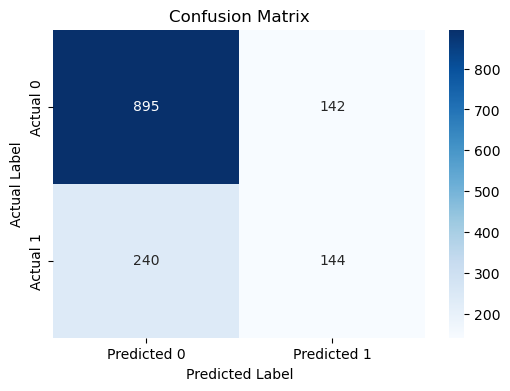

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1037
           1       0.50      0.38      0.43       384

    accuracy                           0.73      1421
   macro avg       0.65      0.62      0.63      1421
weighted avg       0.71      0.73      0.72      1421



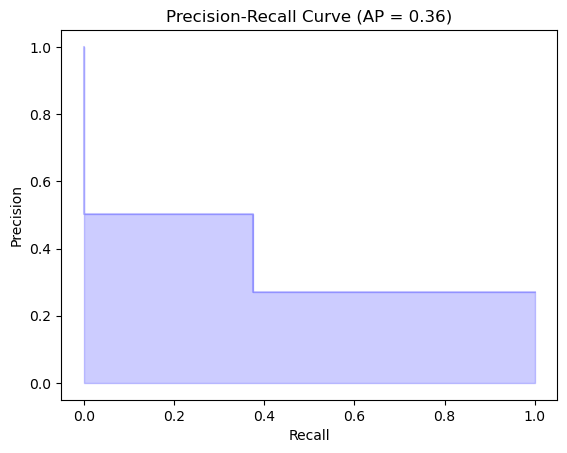

In [1419]:
y_pred2 = model.predict(X_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(test_data['y'], y_pred)


# Precision, Recall, F1-score 계산
precision = precision_score(test_data['y'], y_pred)
recall = recall_score(test_data['y'], y_pred)
f1 = f1_score(test_data['y'], y_pred)
accuracy = accuracy_score(test_data['y'], y_pred)

rounded_accuracy = round(accuracy * 100, 2)
rounded_precision = round(precision * 100, 2)
rounded_recall = round(recall * 100, 2)
rounded_f1 = round(f1 * 100, 2)

print("Test Accuracy:", rounded_accuracy)
print("Precision:", rounded_precision)
print("Recall:", rounded_recall)
print("F1-score:", rounded_f1)


# print("Test Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)

# Confusion Matrix 시각화
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Classification Report 출력
print("Classification Report:")
print(classification_report(test_data['y'], y_pred))

# Precision-Recall Curve 그리기
precision, recall, _ = precision_recall_curve(test_data['y'], y_pred)
average_precision = average_precision_score(test_data['y'], y_pred)
area_under_curve = auc(recall, precision)

# Precision-Recall Curve 시각화
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
# plt.title(f'Precision-Recall Curve (AUC = {area_under_curve:.2f})')
plt.show()


In [1408]:
# feature_importance = model.feature_importances_

# # Get feature names
# feature_names = X_train.columns

# # Create a dictionary to store feature importance values and names
# feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, feature_importance)}

# # Sort the feature importance dictionary by importance values in descending order
# sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# # Get the top 10 important features
# top_10_features = sorted_feature_importance[:10]

# # Extract feature names and importance values from the top 10 features
# top_10_feature_names = [feature[0] for feature in top_10_features]
# top_10_feature_importance = [feature[1] for feature in top_10_features]

# # Invert the lists to reverse the order
# top_10_feature_names.reverse()
# top_10_feature_importance.reverse()

# # Create a bar plot for the top 10 important features
# plt.barh(top_10_feature_names, top_10_feature_importance)
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.title('Top 10 Important Features')
# plt.show()

In [1341]:
# y_pred2 = model.predict(X_train)
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(train_data['y'], y_pred2)
# print("Train Accuracy:", accuracy)
# accuracy = accuracy_score(test_data['y'], y_pred)
# print("Test Accuracy:", accuracy)
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# from sklearn.metrics import precision_score, recall_score, f1_score
# cm = confusion_matrix(test_data['y'], y_pred)
# import matplotlib.pyplot as plt
# # Confusion matrix를 pandas DataFrame으로 변환합니다
# cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# # Confusion matrix를 시각화합니다
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('Actual Label')
# plt.show()

# from sklearn.metrics import classification_report
# print(classification_report(test_data['y'], y_pred))